# ЗАГРУЗКА И АНАЛИЗ ДАННЫХ

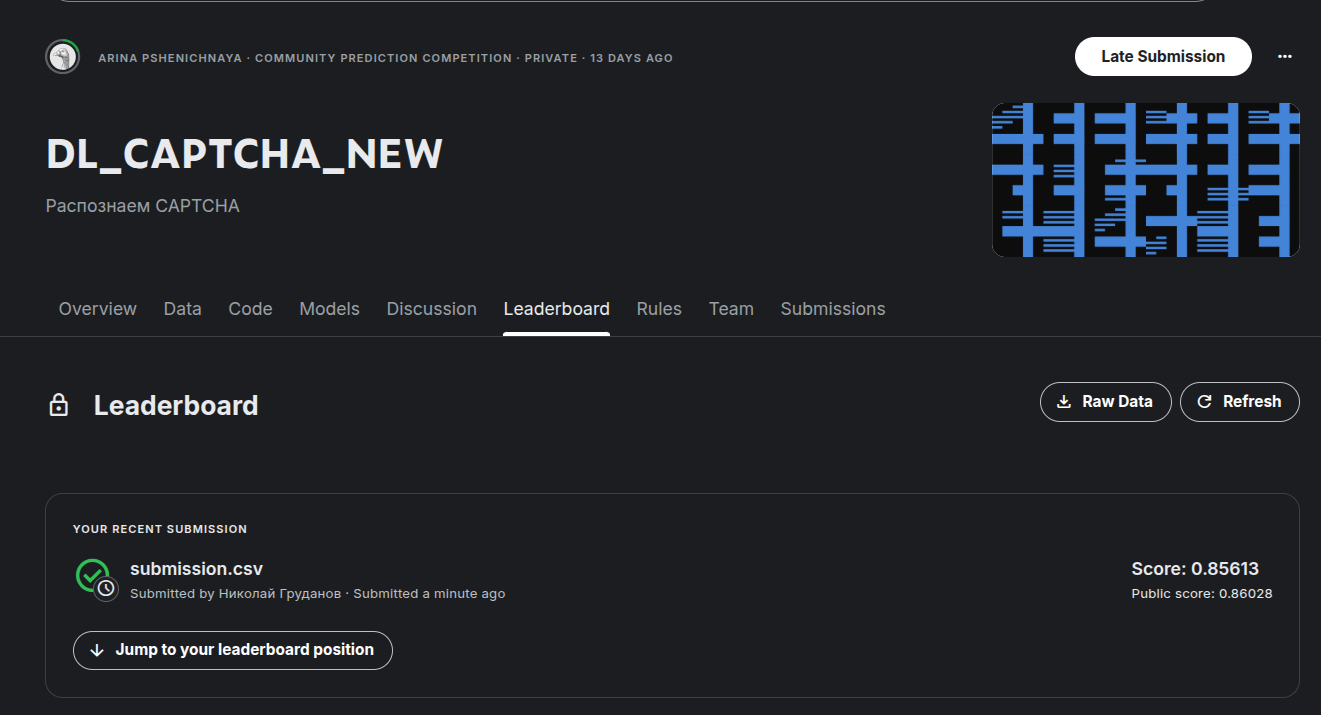

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Настройка для ROCm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

Используется устройство: cuda
GPU: AMD Radeon RX 7800 XT


In [4]:
#загрузка данных
images = np.load('./dl-captcha-new/mds-misis-dl-captchan/images.npy')
labels = np.load('./dl-captcha-new/mds-misis-dl-captchan/labels.npy')
test_images = np.load('./dl-captcha-new/mds-misis-dl-captchan/images_sub.npy')


In [5]:
print('images')
print('')
print(images[0])
print('\n==================================\n')
print('labels')
print('')
print(labels[0])

images

[[[144 109 189]
  [153 122 179]
  [169 143 163]
  ...
  [158 130 175]
  [149 117 183]
  [131  91 200]]

 [[128  87 203]
  [138 101 193]
  [160 132 172]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 199]]

 [[127  86 204]
  [135  96 197]
  [145 111 188]
  ...
  [158 129 175]
  [152 121 181]
  [132  93 198]]

 ...

 [[147 115 185]
  [159 131 174]
  [168 142 165]
  ...
  [159 130 174]
  [154 123 179]
  [137 100 194]]

 [[130  90 201]
  [143 108 189]
  [165 138 168]
  ...
  [159 130 175]
  [153 122 180]
  [131  91 200]]

 [[130  90 201]
  [138 102 194]
  [139 102 193]
  ...
  [158 129 175]
  [148 116 184]
  [128  87 203]]]


labels

13


In [6]:
print(f"Размер обучающих изображений: {images.shape}")
print(f"Размер меток: {labels.shape}")
print(f"Размер тестовых изображений: {test_images.shape}")
print(f"Тип данных изображений: {images.dtype}")
print(f"Диапазон значений пикселей: [{images.min()}, {images.max()}]")
print(f"Количество классов: {len(np.unique(labels))}")

Размер обучающих изображений: (20000, 48, 48, 3)
Размер меток: (20000,)
Размер тестовых изображений: (50000, 48, 48, 3)
Тип данных изображений: uint8
Диапазон значений пикселей: [0, 255]
Количество классов: 26


Text(0, 0.5, 'Количество примеров')

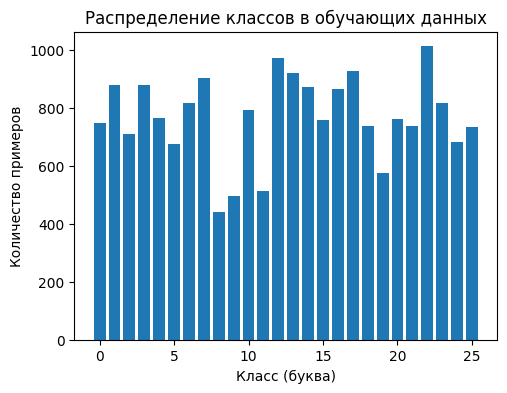

In [7]:
# Анализ распределения классов
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.title('Распределение классов в обучающих данных')
plt.xlabel('Класс (буква)')
plt.ylabel('Количество примеров')

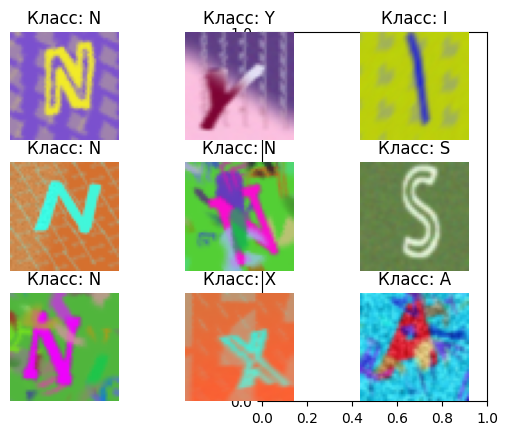

In [8]:
# Показываем примеры изображений
plt.subplot(1, 2, 2)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(f'Класс: {chr(65 + labels[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# ПРЕДОБРАБОТКА ДАННЫХ 

In [9]:
class CaptchaDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Преобразование из numpy в PIL Image, затем в tensor
        if self.transform:
            image = self.transform(image)
        else:
            # Нормализация данных [0, 255] -> [0, 1]
            image = torch.FloatTensor(image) / 255.0
            # Изменение порядка размерностей: (H, W, C) -> (C, H, W)
            image = image.permute(2, 0, 1)
        
        return image, torch.LongTensor([label]).squeeze()

In [10]:
# Создание transforms для аугментации данных
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Разделение данных на train/validation

X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Создание datasets и dataloaders
train_dataset = CaptchaDataset(X_train, y_train, transform=train_transform)
val_dataset = CaptchaDataset(X_val, y_val, transform=train_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# АРХИТЕКТУРА МОДЕЛИ

In [11]:
class CaptchaCNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CaptchaCNN, self).__init__()
        
        # Конволюционные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        # После 3 pooling операций: 48/8 = 6
        self.fc1 = nn.Linear(128 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Конволюционные блоки
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 128 * 6 * 6)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Создание модели
model = CaptchaCNN(num_classes=26).to(device)
print(model)


CaptchaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=26, bias=True)
)


In [12]:
# Функция потерь
criterion = nn.CrossEntropyLoss()

# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Scheduler для изменения learning rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)


Функции обучения и валидации

In [13]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc


Основной цикл обучения

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 30)
        
        # Обучение
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Валидация
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Обновление learning rate
        scheduler.step(val_loss)
        
        # Сохранение метрик
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_captcha_model.pth')
            print(f'Новая лучшая модель сохранена! Точность: {val_acc:.2f}%')
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

# Запуск обучения
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=70)



Epoch 1/70
------------------------------


Batch 0, Loss: 3.4019
Batch 100, Loss: 3.2846
Batch 200, Loss: 3.2434
Batch 300, Loss: 3.1994
Batch 400, Loss: 3.2479
Train Loss: 3.2760, Train Acc: 4.82%
Val Loss: 3.2199, Val Acc: 5.38%
Новая лучшая модель сохранена! Точность: 5.38%

Epoch 2/70
------------------------------
Batch 0, Loss: 3.2191
Batch 100, Loss: 3.2518
Batch 200, Loss: 3.1768
Batch 300, Loss: 3.0919
Batch 400, Loss: 3.0918
Train Loss: 3.1899, Train Acc: 5.59%
Val Loss: 3.1489, Val Acc: 6.17%
Новая лучшая модель сохранена! Точность: 6.17%

Epoch 3/70
------------------------------
Batch 0, Loss: 3.1908
Batch 100, Loss: 3.1573
Batch 200, Loss: 3.0579
Batch 300, Loss: 3.1635
Batch 400, Loss: 3.2207
Train Loss: 3.1516, Train Acc: 6.89%
Val Loss: 3.0973, Val Acc: 8.62%
Новая лучшая модель сохранена! Точность: 8.62%

Epoch 4/70
------------------------------
Batch 0, Loss: 3.1228
Batch 100, Loss: 3.1294
Batch 200, Loss: 3.1571
Batch 300, Loss: 3.2910
Batch 400, Loss: 3.1899
Train Loss: 3.1068, Train Acc: 7.75%
Val Loss: 2

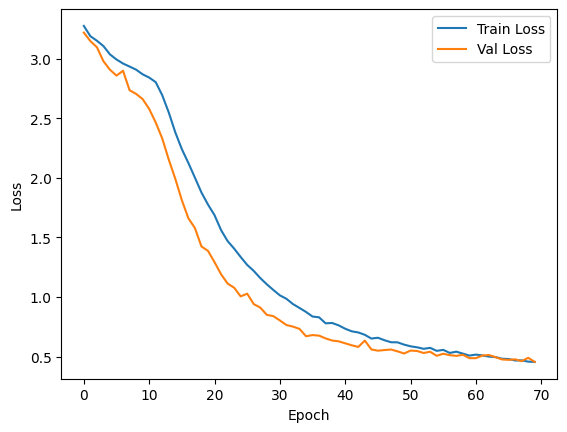

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.get('train_losses', []), label='Train Loss')
plt.plot(history.get('val_losses', []), label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Предсказания на тестовых данных

In [16]:
# Загрузка лучшей модели
model.load_state_dict(torch.load('best_captcha_model.pth'))
model.eval()

# Создание dataset для тестовых данных
test_dataset = CaptchaDataset(test_images, np.zeros(len(test_images)), transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Предсказания
predictions = []
model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

# Создание submission
submission = pd.DataFrame({
    'Id': range(len(predictions)),
    'Category': predictions
})
submission.to_csv('submission.csv', index=False)
